- Notebook réalisé par Mohamed Ali SRIR

# Bibliographie

- S. Kumar. Reinforcement learning code for cartpole system. https://github.com/swagatk/RL-Projects-SK.git, 2020
- S. Kumar. Balancing a CartPole System with Reinforcement Learning - A Tutorial, https://arxiv.org/pdf/2006.04938.pdf?fbclid=IwAR1HWA-WRWQL3BwKAmM7vKq-DePOkjkalVAqFvL61AtlEGigytR6xwlRVQs, 2020

# Les imports

In [2]:
import gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import time

# Création de l'environnement

- Gym est une bibliothèque python qui contient plein de modèle pour l'apprentissage par renforcement : nous allons utilisé un exemple simple celui du CartPole (voir sa description dans le code source https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

- Il est modélisé par un vecteur de 4 dimensions : $ \{ x , \dot x ,\theta ,\dot \theta \}$ respectivement : la position du chariot,  la vitesse du chariot, l'angle de la barre et la vitesse angulaire de la barre.

- Il y a deux actions possible : mouvement droit ou gauche du chariot

- Pour s'entraîner l'algo effectue des épisodes (ici maximum 1000)

- À chaque épisode on prend maximum 200 décisions

- La récompense et calculé comme étant le nombre de tour dans un épisode où la barre est resté stable.

- La stabilité est définie par ses 4 critères :

- - Ne pas dépasser $ \theta $  +- 12° 

- - Ne pas dépasser  $ x $ 2.4 cm

- À chaque décision ou incrémente le Reward de 1, le Reward de l'épisode est donc combien il a gardé la barre stable

- Si le Reward des 100 derniers épisodes a une moyenne supérieur à 195, on considère qu'on est assez proche du Q optimal.

In [3]:
#Importer l'environnement de Gym

env= gym.make('CartPole-v0')

In [4]:
# user-defined parameters
max_episodes = 20000
max_time_steps = 250
streak_to_end = 120
solved_time = 199
discount = 0.99
no_streaks = 0

- Regardons ensembles les valeurs possibles des états du système (soit les plages d'existence de $ x , \dot x ,\theta ,\dot \theta$ )

In [5]:
state_value_bounds = list(zip(env.observation_space.low, 
                              env.observation_space.high)) 

print(state_value_bounds)
print(len(state_value_bounds))
print(np.shape(state_value_bounds))
print(state_value_bounds[0][0])

[(-4.8, 4.8), (-3.4028235e+38, 3.4028235e+38), (-0.41887903, 0.41887903), (-3.4028235e+38, 3.4028235e+38)]
4
(4, 2)
-4.8


- Étant donné qu'on aura besoin de discrétisé (voir cellules suivantes) pour avoir un ensemble fini d'état, on va restreindre les vitesses à de plus petites valeurs (au lieu de + - l'infinie comme présent) pour pouvoir bien subdiviser notre espace sans avoir beaucoup trop d'états. (La manière dont on va le faire va faire en sorte que en dehors de ces vitesses là on considèrera que c'est le même état ça marche plûtot bien (si on a de trop grandes vitesses les chances de rester en équilibre sont pas grande donc intuitivement ça se comprend)).

In [6]:

state_value_bounds[1] = (-0.5, 0.5)
state_value_bounds[3] = (-math.radians(50), math.radians(50))

- Le tuple no_actions représente le nombre d'action possible à chaque instant, dans notre cas c'est deux le chariot peut aller soit à droite soit à gauche à chaque fois.

- Le tuple no_buckets représente le nombre de subdivision de l'espace continu des vecteurs-états. (En prenant 1 pour valeur de position et vitesse on veut dire que toutes les valeurs sont équivalentes)

In [7]:
no_actions = env.action_space.n
no_buckets = (1,1,6,3)

In [8]:
#Fonction de discretisation

def bucketize_state_value(state_value):
    ''' Discretizes continuous values into fixed buckets'''
    #print('len(state_value):', len(state_value))
    bucket_indices = []
    for i in range(len(state_value)):
        if state_value[i] <= state_value_bounds[i][0]:   # violates lower bound
            bucket_index = 0
        elif state_value[i] >= state_value_bounds[i][1]: # violates upper bound
            bucket_index = no_buckets[i] - 1  # put in the last bucket
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (no_buckets[i]-1) * state_value_bounds[i][0] / bound_width
            scaling = (no_buckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state_value[i]-offset))

        bucket_indices.append(bucket_index)
    return(tuple(bucket_indices))


- On initialise arbitrairement Q, c'est une matrice des états $ \times $ actions. On a $ 1 \times 2 \times 6 \times 3 $ états, et 2 actions. L'élément Q[état][action] est l'espérence conditionnelle des récompenses des états futurs sachant qu'on a pris la décision de faire action quand on était à l'état état.

In [9]:
q_value_table = np.zeros(no_buckets + (no_actions,))

# Appliquer l'algorithme de Q-Learning

## La méthode Epsilon-Greedy (Voir La biblio)

In [10]:
# Select an action - explore vs exploit
# epsilon-greedy method

min_explore_rate = 0.1
min_learning_rate = 0.07

def select_action(state_value, explore_rate):
    if random.random() < explore_rate: 
        action = env.action_space.sample()    # explore
    else:
        action = np.argmax(q_value_table[state_value])  # exploit
    return action

def select_explore_rate(x):
    # change the exploration rate over time.
    return max(min_learning_rate, min(1.0, 1.0 - math.log10((x+1)/25)))

def select_learning_rate(x):
    # Change learning rate over time
    return max(min_learning_rate, min(1.0, 1.0 - math.log10((x+1)/25)))

In [11]:
q_value_table = np.zeros(no_buckets + (no_actions,))

_DEBUG = False
frames = []
reward_per_episode = []
time_per_episode = []
avgtime_per_episode = []
learning_rate_per_episode = []
explore_rate_per_episode = []

Qstar = None
evolutionQeps = []



# train the system
totaltime = 0
for episode_no in range(max_episodes):

    explore_rate = select_explore_rate(episode_no)
    learning_rate = select_learning_rate(episode_no)

    learning_rate_per_episode.append(learning_rate)
    explore_rate_per_episode.append(explore_rate)

    # reset the environment while starting a new episode
    observation = env.reset()
    
    start_state_value = bucketize_state_value(observation)
    previous_state_value = start_state_value

    #print(start_state_value)
    #time.sleep(10)


    done = False 
    time_step = 0

    while not done:  
        #env.render()
        action = select_action(previous_state_value, explore_rate)
        observation, reward_gain, done, info = env.step(action)
        #time.sleep(1) voir ce qui se passe à chaque itération
        state_value = bucketize_state_value(observation)
        best_q_value = np.max(q_value_table[state_value])

        #update q_value_table
        q_value_table[previous_state_value][action] += learning_rate * (
            reward_gain + discount * best_q_value - 
            q_value_table[previous_state_value][action])

        #print(q_value_table)

        evolutionQeps.append(max(q_value_table[0][0][3][1]))



        previous_state_value = state_value

        #Enlever le if si vous voulez plus de détails 
        
        if episode_no % 100 == 0 and _DEBUG == True:
            print('Episode number: {}'.format(episode_no))
            print('Time step: {}'.format(time_step))
            print('Previous State Value: {}'.format(previous_state_value))
            print('Selected Action: {}'.format(action))
            print('Current State: {}'.format(str(state_value)))
            print('Reward Obtained: {}'.format(reward_gain))
            print('Best Q Value: {}'.format(best_q_value))
            print('Learning rate: {}'.format(learning_rate))
            print('Explore rate: {}'.format(explore_rate))

        

        time_step += 1
        # while loop ends here

    if time_step >= solved_time:
        no_streaks += 1
    else:
        no_streaks = 0

    if no_streaks > streak_to_end:
        print('CartPole problem is solved after {} episodes.'.format(episode_no))
        break

    # data log
    if episode_no % 100 == 0:  
        print('Episode {} finished after {} time steps'.format(episode_no, time_step))
    time_per_episode.append(time_step)
    totaltime += time_step
    avgtime_per_episode.append(totaltime/(episode_no+1))
    # episode loop ends here




env.close()

Qeps = q_value_table

print(Qeps)

#print(evolutionQ)

Episode 0 finished after 37 time steps
Episode 100 finished after 112 time steps
Episode 200 finished after 200 time steps
CartPole problem is solved after 294 episodes.
[[[[[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]

   [[46.47580138 48.77517088]
    [37.29182269 45.0549841 ]
    [ 0.95078198 67.59046517]]

   [[99.4464887  97.53380549]
    [99.46270445 99.37322387]
    [99.11086664 99.46103548]]

   [[99.45853951 98.88913635]
    [99.38848648 99.46115693]
    [97.86852555 99.43758912]]

   [[25.57415388  0.        ]
    [31.76888278 33.87436817]
    [41.12010431 38.3447952 ]]

   [[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]]]]


## Learning rate et exploration rate constant

In [12]:
q_value_table = np.zeros(no_buckets + (no_actions,))

min_explore_rate = 0.1
min_learning_rate = 0.07

_DEBUG = False
frames = []
reward_per_episode = []
time_per_episode = []
avgtime_per_episode = []
learning_rate_per_episode = []
explore_rate_per_episode = []

evolutionQcst = []



# train the system
totaltime = 0
for episode_no in range(max_episodes):

    explore_rate = min_explore_rate
    learning_rate = min_learning_rate

    learning_rate_per_episode.append(learning_rate)
    explore_rate_per_episode.append(explore_rate)

    # reset the environment while starting a new episode
    observation = env.reset()
    
    start_state_value = bucketize_state_value(observation)
    previous_state_value = start_state_value

    #print(start_state_value)
    #time.sleep(10)


    done = False 
    time_step = 0

    while not done:  
        #env.render()
        action = select_action(previous_state_value, explore_rate)
        observation, reward_gain, done, info = env.step(action)
        #time.sleep(1) voir ce qui se passe à chaque itération
        state_value = bucketize_state_value(observation)
        best_q_value = np.max(q_value_table[state_value])

        #update q_value_table
        q_value_table[previous_state_value][action] += learning_rate * (
            reward_gain + discount * best_q_value - 
            q_value_table[previous_state_value][action])

        #print(q_value_table)

        evolutionQeps.append(max(q_value_table[0][0][3][1]))



        previous_state_value = state_value

        #Enlever le if si vous voulez plus de détails 
        
        if episode_no % 100 == 0 and _DEBUG == True:
            print('Episode number: {}'.format(episode_no))
            print('Time step: {}'.format(time_step))
            print('Previous State Value: {}'.format(previous_state_value))
            print('Selected Action: {}'.format(action))
            print('Current State: {}'.format(str(state_value)))
            print('Reward Obtained: {}'.format(reward_gain))
            print('Best Q Value: {}'.format(best_q_value))
            print('Learning rate: {}'.format(learning_rate))
            print('Explore rate: {}'.format(explore_rate))

        

        time_step += 1
        # while loop ends here

    if time_step >= solved_time:
        no_streaks += 1
    else:
        no_streaks = 0

    if no_streaks > streak_to_end:
        print('CartPole problem is solved after {} episodes.'.format(episode_no))
        break

    # data log
    if episode_no % 100 == 0:  
        print('Episode {} finished after {} time steps'.format(episode_no, time_step))
    time_per_episode.append(time_step)
    totaltime += time_step
    avgtime_per_episode.append(totaltime/(episode_no+1))
    # episode loop ends here




env.close()

Qcst = q_value_table

print(Qcst)

#print(evolutionQ)

Episode 0 finished after 10 time steps
Episode 100 finished after 12 time steps
Episode 200 finished after 9 time steps
Episode 300 finished after 8 time steps
Episode 400 finished after 11 time steps
Episode 500 finished after 9 time steps
Episode 600 finished after 9 time steps
Episode 700 finished after 9 time steps
Episode 800 finished after 10 time steps
Episode 900 finished after 8 time steps
Episode 1000 finished after 8 time steps
Episode 1100 finished after 10 time steps
Episode 1200 finished after 12 time steps
Episode 1300 finished after 9 time steps
Episode 1400 finished after 9 time steps
Episode 1500 finished after 10 time steps
Episode 1600 finished after 11 time steps
Episode 1700 finished after 8 time steps
Episode 1800 finished after 12 time steps
Episode 1900 finished after 14 time steps
Episode 2000 finished after 9 time steps
Episode 2100 finished after 9 time steps
Episode 2200 finished after 9 time steps
Episode 2300 finished after 10 time steps
Episode 2400 fini

## Tester notre modèle entrainé

- On va suivre la meilleur décision selon notre algo et voir si ça marche

In [13]:
def select_action_trained(state_value, Q):
    
    action = np.argmax(Q[state_value])
    return action

In [14]:
Qaleatoire = np.zeros(no_buckets + (no_actions,))

for i in range (20) :

    for episode_no in range(10):
        
        observation = env.reset()
        start_state_value = bucketize_state_value(observation)
        previous_state_value = start_state_value
        done = False 
        time_step = 0
    
        while not done:  
                
            env.render()

            action = select_action_trained(previous_state_value, Qaleatoire)
            observation, reward_gain, done, info = env.step(action)
            #time.sleep(1) voir ce qui se passe à chaque itération
            state_value = bucketize_state_value(observation)
            previous_state_value = state_value

                    #Enlever le if si vous voulez plus de détails 
            
            if episode_no % 100 == 0 and _DEBUG == True:
                print('Episode number: {}'.format(episode_no))
                print('Time step: {}'.format(time_step))
                print('Previous State Value: {}'.format(previous_state_value))
                print('Selected Action: {}'.format(action))
                print('Current State: {}'.format(str(state_value)))
                print('Reward Obtained: {}'.format(reward_gain))
                print('Best Q Value: {}'.format(best_q_value))
                print('Learning rate: {}'.format(learning_rate))
                print('Explore rate: {}'.format(explore_rate))

            

            time_step += 1
            # while loop ends here

        if time_step >= solved_time:
            no_streaks += 1
        else:
            no_streaks = 0


        # data log
        if episode_no % 100 == 0:  
            print('Test {} finished after {} time steps'.format(i, time_step))
        time_per_episode.append(time_step)
        totaltime += time_step
        avgtime_per_episode.append(totaltime/(episode_no+1))
        # episode loop ends here


   

Test 0 finished after 200 time steps
Test 1 finished after 200 time steps
Test 2 finished after 200 time steps


KeyboardInterrupt: 

In [ ]:
env.close()

## Étudier l'effet de certains paramètre

### Le paramètre $ \alpha $
- On veut voir l'effet du Learning rate sur la variation de $ Q(s,a) $ pour un état donné.

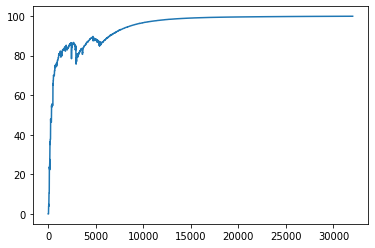

In [ ]:
plt.plot(evolutionQeps)
plt.show()